## Gaussian Correlation

The goal of the project is to check the sensitivity of a Basket Default Swap (BDS) to maturity and correlation. 

Consider a 3rd-to-default BDS on a basket of 5 reference entities whose default intensities are equal to 0.15. They also share the same notional, 1M, and recovery rate, 40%. The correlation structure is as follows:
* $\rho_{12} = 0.3$
* $\rho_{45} = 0.7$
* $\rho_{13} = 0.4$
* $\rho = 0.25$ between all the others

The input parameters are:

* the market quotes of a set of Overnight Index Swaps;
* the description of the contract.

You are required to find:
1. assuming a Gaussian correlation between the assets determine the BDS spread for maturities ranging between 1 and 10 years.
2. if you then assume that the correlation is the same between each reference entity: draw a plot showing how the spread varies as a function of the correlation for various values of $\rho = [0.01, 0.1, 0.25, 0.50, 0.75, 0.99]$) and for maturities ranging between 1 and 10 years.

Comment the result.

### Notes and hints

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for multi-curve evaluation.

Remember to reuse the code we developed during the lessons in `finmarkets.py` as much as possible, instead of trying to rewrite everything from scratch!

When not possible develop your own classes.

## Inputs

[Overnight swap quotes](https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/ois_quotes.csv)

In [3]:
from datetime import date
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.integrate import quad
from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import math
import matplotlib.pyplot as plt

In [4]:

pricing_date = date.today()

N = 5
n_def = 3
rho_12 = 0.3
rho_45 = 0.7
rho_13 = 0.4
rho = 0.25
nominal = 1e6
R = 0.4
l = 0.15 # lambda


In [5]:

# function to generate date (not changed from the one in "finmarkets")
def generate_dates(start_date, n_months, tenor_months=12):
  dates = []

  for n in range(0, n_months, tenor_months):
    dates.append(start_date + relativedelta(months=n))
  dates.append(start_date + relativedelta(months=n_months))
  return dates   


In [6]:
# function to be minimized in the bootstraping 
def fct_to_minim(x,pillars,swaps):
    x = np.insert(x, 0, 1)    
    dc=DiscountCurve(pillars, x)
    sm=0
    for i in swaps:
        sm+=i.npv(dc)**2
    return sm

In [7]:
# Discount curve class (not changed from the one in "finmarkets")
class DiscountCurve:
  def __init__(self, pillar_dates, discount_factors):
    self.start_date = pillar_dates[0]
    self.pillar_dates = [(p-self.start_date).days for p in pillar_dates]
    self.discount_factors = [math.log(discount_factor)for discount_factor in discount_factors]

  def df(self, d):
    d_days = (d - self.start_date).days
    interpolated_df = np.interp(d_days, self.pillar_dates, self.discount_factors)
    return math.exp(interpolated_df) 

In [8]:
# class for the ois (it's the same of the one in 'finmarkets')
class OvernightIndexSwap:
  def __init__(self, notional, start_date, fixed_rate, maturity_months):
    self.notional = notional
    self.payment_dates = generate_dates(start_date, maturity_months)
    self.fixed_rate = fixed_rate
    
  def __str__(self):
    s = "This is an OvernightIndexSwap with a notional of {}\n".format(self.notional)
    s += "And the following payment_dates {}".format(self.payment_dates)
    return s
        
  def npv_floating_leg(self, dc):
    return self.notional * (dc.df(self.payment_dates[0]) - dc.df(self.payment_dates[-1]))
    
  def npv_fixed_leg(self, dc):
    npv = 0
    for i in range(1, len(self.payment_dates)):   
      start_date = self.payment_dates[i-1]
      end_date = self.payment_dates[i]
      tau = (end_date - start_date).days / 360
      df = dc.df(end_date)
      npv = npv + df * tau
    return self.notional * self.fixed_rate * npv
    
  def npv(self, discount_curve):
    float_npv = self.npv_floating_leg(discount_curve)
    fixed_npv = self.npv_fixed_leg(discount_curve)
    return float_npv - fixed_npv

In [9]:
# class to find the credit curve (there are some change from the one in "finmarkets")
class CreditCurve:
  def __init__(self, pillar_dates, pillar_ndps):
    self.pillar_dates = pillar_dates
    self.pillar_ndps = pillar_ndps
    self.pillar_days = [(pd - pillar_dates[0]).days for pd in pillar_dates]
    self.log_ndps = [math.log(ndp+0.00000001) for ndp in pillar_ndps]

  def ndp(self,value_date):
    value_days = (value_date - self.pillar_dates[0]).days
    a=math.exp(np.interp(value_days, self.pillar_days, self.log_ndps))
    return a

In [10]:
# class to find density,cumulative and percent point fct of default (no change from the one in finmarkets)
import random

class ExpDefault(rv_continuous): 
  def __init__(self, l):
    np.random.seed(int(random.random()*1000000))
    super().__init__()
    self.ulim = 100
    self.l = l
    self.ppf_func = self.prepare_ppf()

  def _cdf(self, x):
    x[x < 0] = 0
    return (1 - np.exp(-self.l*x))

  def _pdf(self, x):
    x[x < 0] = 0
    return self.l*np.exp(-self.l*x)

  def _ppf(self, x):
    return self.ppf_func(x)
  
  def prepare_ppf(self):
    xs = np.linspace(0, self.ulim, 10000001)
    cdf = self.cdf(xs)/self.cdf(xs[-1])
    func_ppf = interp1d(cdf, xs, fill_value='extrapolate')
    return func_ppf


In [11]:
# credit default basket class ( i merged in that some part of the class credit default swap and changed some part to match it with the rest of code )
class BasketDefaultSwaps:
  def __init__(self, nominal, start_date,  maturity,spread, 
               hazard_rate, rho, N, pillars,
               tenor=3, recovery=0.4):
    self.spread=spread
    self.recovery=recovery
    self.nominal=nominal
    self.pillars=pillars
    self.payment_dates = generate_dates(start_date,maturity*12, tenor)
    self.Q = ExpDefault(l=hazard_rate)
    self.N = N
    self.rho = rho
    self.cc = None

  def credit_curve(self, n_defaults):
    simulations = 100000
    cov = np.ones(shape=(self.N, self.N))*self.rho
    np.fill_diagonal(cov, 1)
    mean = np.zeros(self.N)
    mv = multivariate_normal(mean=mean, cov=cov)
    x = mv.rvs(size=simulations)
    x_unif = norm.cdf(x)
    default_times = self.Q.ppf(x_unif)

    Ts = [(p-self.pillars[0]).days/360 for p in self.pillars]
    ndps = []
    for t in Ts:
      b = np.count_nonzero(default_times<=t, axis=1)
      ndps.append(1 - len(b[b>=n_defaults])/simulations)
    self.cc = CreditCurve(pillars, ndps)

  def npv(self, dc):
    if self.cc is None:
      print ("Need to call credit_curve method first !")
      return None
    return self.cds.npv(dc, self.cc)
  
  def npv_premium_leg(self, discount_curve): 
    val = 0
    for i in range(1, len(self.payment_dates)): 
      val += (self.spread *discount_curve.df(self.payment_dates[i]) *self.cc.ndp(self.payment_dates[i])) 
    return val * self.nominal

  def npv_default_leg(self, discount_curve): 
    val = 0
    d = self.payment_dates[0]
    while d <= self.payment_dates[-1]:
      p1=discount_curve.df(d)
      p2=self.cc.ndp(d)
      nd=d + relativedelta(days=1)
      p3=self.cc.ndp(nd)
      val += p1 * (p2-p3)
      d += relativedelta(days=1)
    return val * self.nominal * (1 - self.recovery)


In [12]:
import pandas as pd

# data 
N = 5
n_def = 3
rho_12 = 0.3
rho_45 = 0.7
rho_13 = 0.4
rho = 0.25
nominal = 1e6
R = 0.4
l = 0.0001 # lambda

oisq = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/ois_quotes.csv")

cov_mat=np.ones([N, N])*rho
cov_mat[0,1]=rho_12
cov_mat[1,0]=rho_12
cov_mat[3,4]=rho_45
cov_mat[4,3]=rho_45
cov_mat[0,2]=rho_13
cov_mat[2,0]=rho_13
cov_mat[1,1]=1
cov_mat[2,2]=1
cov_mat[3,3]=1
cov_mat[4,4]=1
cov_mat[0,0]=1

today=date.today()
pillar_date=[today]
swaps=[]

In [13]:
#bootstraping from ois quote of the discount factor curve 
for i in range(len(oisq)):
    swap=OvernightIndexSwap(1, today, 0.01*oisq["quote"].iloc[i], int(oisq['months'].iloc[i]))
    swaps.append(swap)
    pillar_date.append(swap.payment_dates[-1])

x0=[1 for i in range(len(oisq))]
bounds=[(0.01,10) for i in range(len(oisq))]
res=minimize(fct_to_minim, x0, bounds=bounds, args=(pillar_date,swaps))
discountfc=res['x']
discountfc=np.insert(discountfc, 0, 1)
dc = DiscountCurve(pillar_date, discountfc)

Text(0.5, 1.0, 'Discount Curve')

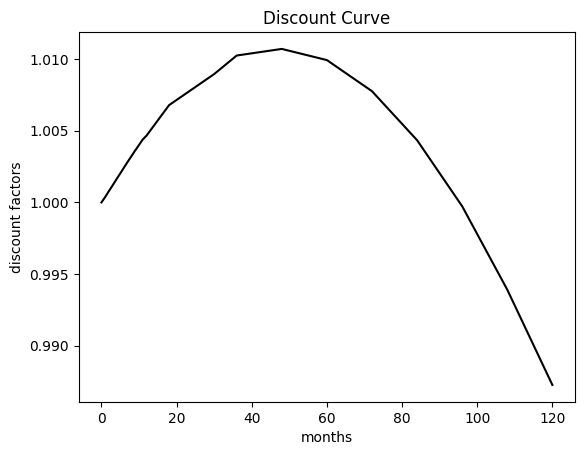

In [14]:
t1=np.insert(np.array(oisq['months']), 0, 0)

plt.plot(t1[:-9],discountfc[:-9],color='k')
plt.xlabel('')
plt.ylabel('discount factors')
plt.xlabel('months')
plt.title("Discount Curve")

In [15]:
from datetime import date
from dateutil.relativedelta import relativedelta

#create 2 lists, the first to contain credit default basket with different time horizon, the second to contain the breakeven rate 
bds_l=[]
ber=[]
pillars = [today + relativedelta(months=6*i) for i in range(30)]

for i in range(1, 11):
  bds = BasketDefaultSwaps(nominal, today, i, 0.01, l, cov_mat, N, pillars)
  bds.credit_curve(n_def)
  bds_l.append(bds)

# compute the break even rates from the different maturity credit default basket and put the rates in the ber list
for i in range(len(bds_l)):
  num = bds_l[i].npv_default_leg(dc)
  den = bds_l[i].npv_premium_leg(dc)/bds_l[i].spread 
  ber.append(num/den)

/var/folders/kc/4tv45m2j1llfjkv_fvz_tv8m0000gn/T/ipykernel_9683/1945240344.py:13: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  x[x < 0] = 0


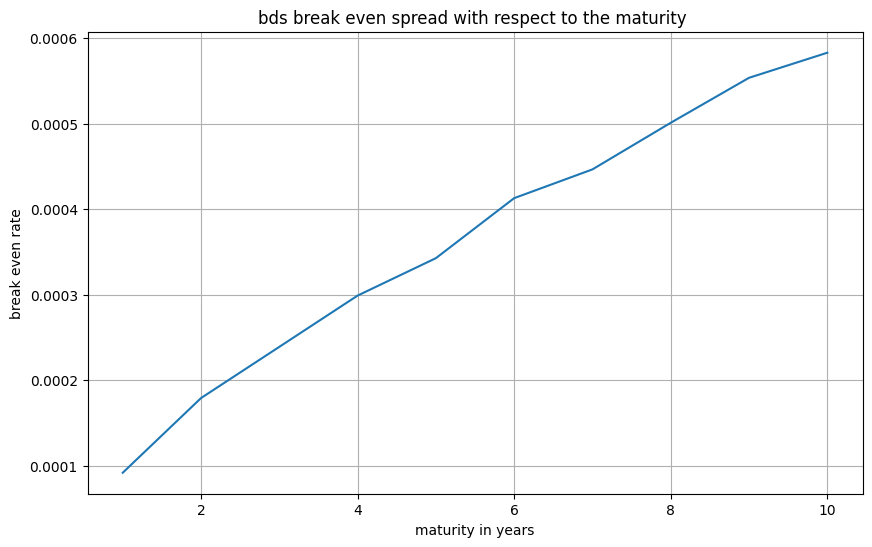

In [16]:


plt.rcParams['figure.figsize'] = (10, 6)

# MIGLIORA UN PO' QUESTO PLOT, CON LE LABEL NEGLI ASSI PER ESEMPIO
t = np.linspace(1, 10, 10)
plt.plot(t, ber)
plt.grid(True)
plt.title('bds break even spread with respect to the maturity ')
plt.xlabel('maturity in years')
plt.ylabel('break even rate')
plt.show()

In [18]:
#hipotesis of different correlation of default
hprho=[0.01, 0.1, 0.25, 0.50, 0.75, 0.99]
spreadhpcorr = np.zeros(shape=(len(hprho), 11))
ndps = np.zeros(shape=(len(hprho), 11))

for i, rho in enumerate(hprho):
  hpmat=np.ones_like(cov_mat)*rho
  np.fill_diagonal(hpmat, 1)
  for j in range(1,11):
    sswap = BasketDefaultSwaps(nominal, today, j, 0.01, l, hpmat, N, pillars)
    sswap.credit_curve(n_def)
    num = sswap.npv_default_leg(dc)
    den = sswap.npv_premium_leg(dc)/sswap.spread 
    spreadhpcorr[i, j] = num/den

  for ip, p in enumerate([today+relativedelta(years=y) for y in range(1, 11)]):
    ndps[i, ip] = sswap.cc.ndp(p)

/var/folders/kc/4tv45m2j1llfjkv_fvz_tv8m0000gn/T/ipykernel_9683/1945240344.py:13: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  x[x < 0] = 0


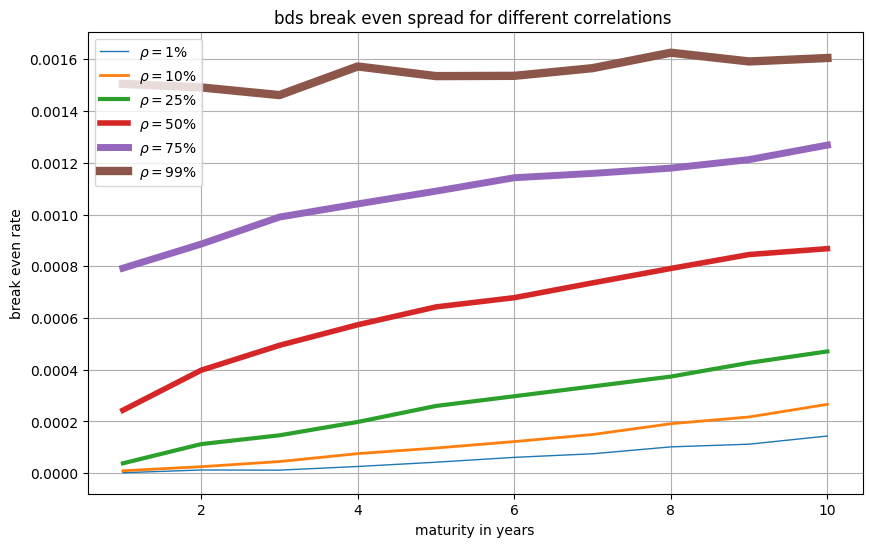

In [19]:
for i, r in enumerate(hprho):
  plt.plot(range(1, 11), spreadhpcorr[i, 1:], label=r'$\rho=${:.0f}%'.format(r*100), linewidth=i+1)

plt.title('bds break even spread for different correlations ')
plt.xlabel('maturity in years')
plt.ylabel('break even rate')
plt.grid(True)
plt.legend()
plt.show()


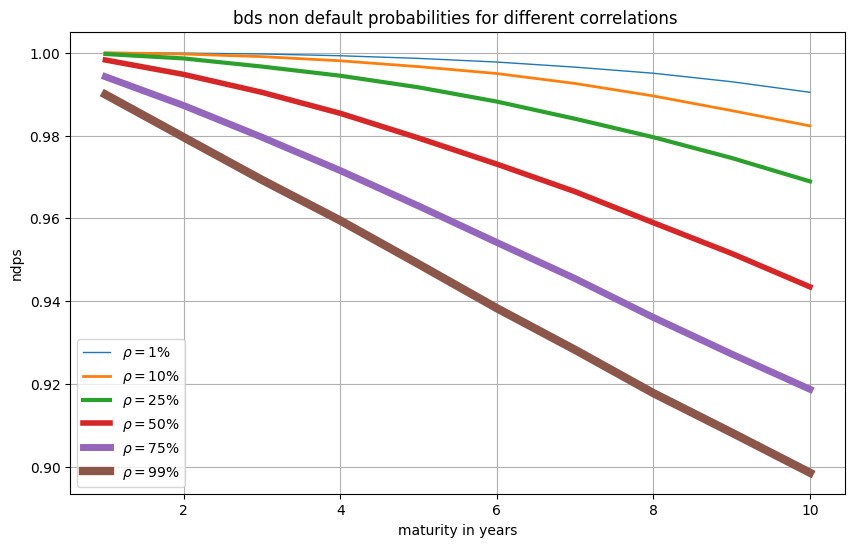

In [20]:
for i, r in enumerate(hprho):
  plt.plot(np.linspace(1,10, 10), ndps[i,:-1],label=r'$\rho=${:.0f}%'.format(r*100), linewidth=i+1)
plt.grid(True)
plt.title('bds non default probabilities for different correlations ')
plt.xlabel('maturity in years')
plt.ylabel('ndps')
plt.legend()
plt.show()

COMMENT:
The main goal of the project was to study change in the spread of a 3rd-to-default credit default basket due to the maturity and correlation.
Correlation near to one means that the default of only one credit results with the default of also other credits and so the activation of the insurance, 
instead a correlation near to 0 means that the credits default probabilities are uncorrelated, so the activation of the insurance happens only after the default of 3 independents credits.
In general a basket with higher default probability has higher spread compensation for risk.
The default of the high correlated basket is more likely to happen than the one of the low correlated basket, so the spread is higher.
As we can see from the graphs the spread of the high correlated basket tends to be constant with respect to time, while the one of the low correlated bds tends to increase with the increase of the maturity,
This effect cames from the fact that in the high correlated bds the non default probability decreases slower that in the uncorrelated bds with respect to maturity, 
we could see better this effect analizing a larger time horizon, we could see also a moment where the non default probability of the low correlated asset decrease under the one of the high correlated basket and so the spread of the first becomes higher than the one of the second.
Till now all results are intuitive but focusing our attention on the "bds break even spread for different correlations" plot we can notice that rising the correlation the spread curve tends to flatten ,this is an inusual result, it means that an increment in the risk due to the probability of default is not compensated by an increment in the spread.
With professor Sani we arrived to the conclusion that we can explain this result by looking at the time density distribution of default of the third entity of the basket, 
in low correlated bds the probability of default tends to increase in time, that intoduces new risk to be compensated with an increasing spread,
for the highly correlated basket the probability is constant with respect to the time, so there is no new risk to compensate.